# Calculate VPD

**Author**: Lukas Hörtnagl (holukas@ethz.ch)

</br>

# Imports

In [1]:
import importlib.metadata
import warnings
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import diive as dv
from diive.core.io.files import save_parquet, load_parquet
from diive.pkgs.createvar.vpd import calc_vpd_from_ta_rh
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.87.1


# Load data

In [2]:
SOURCEDIR = r""
FILENAME = r"12.3_METEO_GAPFILLED_2004-2024.parquet"
FILEPATH = Path(SOURCEDIR) / FILENAME
df = load_parquet(filepath=FILEPATH)
df

Loaded .parquet file 12.3_METEO_GAPFILLED_2004-2024.parquet (0.045 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


,LW_IN_T1_47_1,PA_T1_47_1,PPFD_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1,SW_IN_T1_47_1_gfXG,TA_T1_47_1_gfXG,PPFD_IN_T1_47_1_gfXG
TIMESTAMP_MIDDLE,,,,,,,,,
2004-09-20 10:45:00,NaN,NaN,1070.543364,80.503701,NaN,13.300000,602.874084,13.300000,1070.543364
2004-09-20 11:15:00,NaN,NaN,881.543364,77.503701,NaN,13.390000,703.762207,13.390000,881.543364
2004-09-20 11:45:00,NaN,NaN,1022.543364,75.803704,NaN,13.810000,537.947327,13.810000,1022.543364
2004-09-20 12:15:00,NaN,NaN,1284.543364,71.503701,NaN,14.470000,634.747437,14.470000,1284.543364
2004-09-20 12:45:00,NaN,NaN,742.543364,72.703705,NaN,13.980000,634.747437,13.980000,742.543364
...,...,...,...,...,...,...,...,...,...
2024-12-31 21:45:00,232.595527,94.211806,0.000000,87.254008,0.0,-0.504794,0.000000,-0.504794,0.000000
2024-12-31 22:15:00,232.609777,94.189013,0.000000,87.430236,0.0,-0.296828,0.000000,-0.296828,0.000000
2024-12-31 22:45:00,232.345020,94.169525,0.000000,89.787920,0.0,-0.392922,0.000000,-0.392922,0.000000


In [3]:
df.index

DatetimeIndex(['2004-09-20 10:45:00', '2004-09-20 11:15:00', '2004-09-20 11:45:00', '2004-09-20 12:15:00', '2004-09-20 12:45:00', '2004-09-20 13:15:00', '2004-09-20 13:45:00', '2004-09-20 14:15:00', '2004-09-20 14:45:00', '2004-09-20 15:15:00',
               ...
               '2024-12-31 19:15:00', '2024-12-31 19:45:00', '2024-12-31 20:15:00', '2024-12-31 20:45:00', '2024-12-31 21:15:00', '2024-12-31 21:45:00', '2024-12-31 22:15:00', '2024-12-31 22:45:00', '2024-12-31 23:15:00', '2024-12-31 23:45:00'], dtype='datetime64[ns]', name='TIMESTAMP_MIDDLE', length=355563, freq='30min')

</br>

# Calculate VPD (kPa)

In [4]:
vpd = calc_vpd_from_ta_rh(df=df, rh_col='RH_T1_47_1', ta_col='TA_T1_47_1_gfXG')
vpd

TIMESTAMP_MIDDLE
2004-09-20 10:45:00    0.298200
2004-09-20 11:15:00    0.346113
2004-09-20 11:45:00    0.382596
2004-09-20 12:15:00    0.470299
2004-09-20 12:45:00    0.436409
                         ...   
2024-12-31 21:45:00    0.075030
2024-12-31 22:15:00    0.075127
2024-12-31 22:45:00    0.060608
2024-12-31 23:15:00    0.117695
2024-12-31 23:45:00    0.069221
Freq: 30min, Name: VPD, Length: 355563, dtype: float64

In [5]:
df['VPD_T1_47_1'] = vpd

</br>

# Gap-filling

In [6]:
_df = pd.DataFrame()
_df['VPD_T1_47_1'] = df[['VPD_T1_47_1']].copy()
_df['SW_IN_T1_47_1_gfXG'] = df[['SW_IN_T1_47_1_gfXG']].copy()
_df['TA_T1_47_1_gfXG'] = df[['TA_T1_47_1_gfXG']].copy()
_df

,VPD_T1_47_1,SW_IN_T1_47_1_gfXG,TA_T1_47_1_gfXG
TIMESTAMP_MIDDLE,,,
2004-09-20 10:45:00,0.298200,602.874084,13.300000
2004-09-20 11:15:00,0.346113,703.762207,13.390000
2004-09-20 11:45:00,0.382596,537.947327,13.810000
2004-09-20 12:15:00,0.470299,634.747437,14.470000
2004-09-20 12:45:00,0.436409,634.747437,13.980000
...,...,...,...
2024-12-31 21:45:00,0.075030,0.000000,-0.504794
2024-12-31 22:15:00,0.075127,0.000000,-0.296828
2024-12-31 22:45:00,0.060608,0.000000,-0.392922


In [7]:
_df['VPD_T1_47_1'].isnull().sum()

np.int64(2789)

### Fill

In [8]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='VPD_T1_47_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 355563.


In [9]:
xgb.reduce_features()
xgb.report_feature_reduction()


[ FEATURE REDUCTION ] Feature reduction based on permutation importance ...
[0]	validation_0-rmse:0.34638	validation_1-rmse:0.34638
[1]	validation_0-rmse:0.27214	validation_1-rmse:0.27214
[2]	validation_0-rmse:0.22540	validation_1-rmse:0.22540
[3]	validation_0-rmse:0.19670	validation_1-rmse:0.19670
[4]	validation_0-rmse:0.17956	validation_1-rmse:0.17956
[5]	validation_0-rmse:0.16957	validation_1-rmse:0.16957
[6]	validation_0-rmse:0.16303	validation_1-rmse:0.16303
[7]	validation_0-rmse:0.15902	validation_1-rmse:0.15902
[8]	validation_0-rmse:0.15599	validation_1-rmse:0.15599
[9]	validation_0-rmse:0.15388	validation_1-rmse:0.15388
[10]	validation_0-rmse:0.15240	validation_1-rmse:0.15240
[11]	validation_0-rmse:0.15055	validation_1-rmse:0.15055
[12]	validation_0-rmse:0.14918	validation_1-rmse:0.14918
[13]	validation_0-rmse:0.14811	validation_1-rmse:0.14811
[14]	validation_0-rmse:0.14722	validation_1-rmse:0.14722
[15]	validation_0-rmse:0.14568	validation_1-rmse:0.14568
[16]	validation_0-rms

In [10]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2004-09-20 11:15:00 and 2024-12-31 23:15:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:0.34638	validation_1-rmse:0.34454
[1]	validation_0-rmse:0.27214	validation_1-rmse:0.27076
[2]	validation_0-rmse:0.22540	validation_1-rmse:0.22448
[3]	validation_0-rmse:0.19670	validation_1-rmse:0.19623
[4]	validation_0-rmse:0.17956	validation_1-rmse:0.17935
[5]	validation_0-rmse:0.16957	validation_1-rmse:0.16975
[6]	validation_0-rmse:0.16303	validation_1-rmse:0.16355
[7]	validation_0-rmse:0.15902	validation_1-rmse:0.15969
[8]	validation_0-rmse:0.15599	validation_1-rmse:0.15679
[9]	validation_0-rmse:0.15388	validation_1-rmse:0.15478
[10]	validation_0-rmse:0.15240	validation_1-rmse:0.15334
[11]	validation_0-rmse:0.15055	validation_1-rmse:0.15162
[12]	validation_0-rmse:0.14918	validation_1-rmse:0.15028
[13]	validation_0-rmse:0.14812	validation_1-rmse:0.14928
[14]	validation_0-r

In [11]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target VPD_T1_47_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting VPD_T1_47_1 ...
>>> Predicting target VPD_T1_47_1 where all features are available ... predicted 355563 records.
>>> Collecting results for final model ...
>>> Filling 2789 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable VPD_T1_47_1_gfXG ...
>>> Restoring original timestamp in results ...

Gap-filling 0 remaining missing records in VPD_T1_47_1_gfXG using fallback model ...
>>> Fallback model not necessary, all gaps were already filled.
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (2789 values, VPD_T1_47_1_gfXG where flag=1) in comparison to observed targets (3

### Results

In [12]:
results = xgb.gapfilling_df_
results

,.PREDICTIONS_FULLMODEL,VPD_T1_47_1,.GAP_PREDICTIONS,FLAG_VPD_T1_47_1_gfXG_ISFILLED,VPD_T1_47_1_gfXG,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2004-09-20 10:45:00,0.267818,0.298200,NaN,0,0.298200,None,0.298200,0.267818
2004-09-20 11:15:00,0.342636,0.346113,NaN,0,0.346113,None,0.644313,0.342636
2004-09-20 11:45:00,0.290778,0.382596,NaN,0,0.382596,None,1.026909,0.290778
2004-09-20 12:15:00,0.457698,0.470299,NaN,0,0.470299,None,1.497208,0.457698
2004-09-20 12:45:00,0.430566,0.436409,NaN,0,0.436409,None,1.933617,0.430566
...,...,...,...,...,...,...,...,...
2024-12-31 21:45:00,0.069147,0.075030,NaN,0,0.075030,None,124886.882984,0.069147
2024-12-31 22:15:00,0.086910,0.075127,NaN,0,0.075127,None,124886.958111,0.086910
2024-12-31 22:45:00,0.085852,0.060608,NaN,0,0.060608,None,124887.018719,0.085852


### Add to data

In [13]:
# Combine data
df['VPD_T1_47_1_gfXG'] = results['VPD_T1_47_1_gfXG'].copy()
df['VPD_T1_47_1_gfXG']

TIMESTAMP_MIDDLE
2004-09-20 10:45:00    0.298200
2004-09-20 11:15:00    0.346113
2004-09-20 11:45:00    0.382596
2004-09-20 12:15:00    0.470299
2004-09-20 12:45:00    0.436409
                         ...   
2024-12-31 21:45:00    0.075030
2024-12-31 22:15:00    0.075127
2024-12-31 22:45:00    0.060608
2024-12-31 23:15:00    0.117695
2024-12-31 23:45:00    0.069221
Freq: 30min, Name: VPD_T1_47_1_gfXG, Length: 355563, dtype: float64

In [14]:
# Flag
df['FLAG_VPD_T1_47_1_gfXG_ISFILLED'] = results['FLAG_VPD_T1_47_1_gfXG_ISFILLED'].copy()
df['FLAG_VPD_T1_47_1_gfXG_ISFILLED']

TIMESTAMP_MIDDLE
2004-09-20 10:45:00    0
2004-09-20 11:15:00    0
2004-09-20 11:45:00    0
2004-09-20 12:15:00    0
2004-09-20 12:45:00    0
                      ..
2024-12-31 21:45:00    0
2024-12-31 22:15:00    0
2024-12-31 22:45:00    0
2024-12-31 23:15:00    0
2024-12-31 23:45:00    0
Freq: 30min, Name: FLAG_VPD_T1_47_1_gfXG_ISFILLED, Length: 355563, dtype: int64

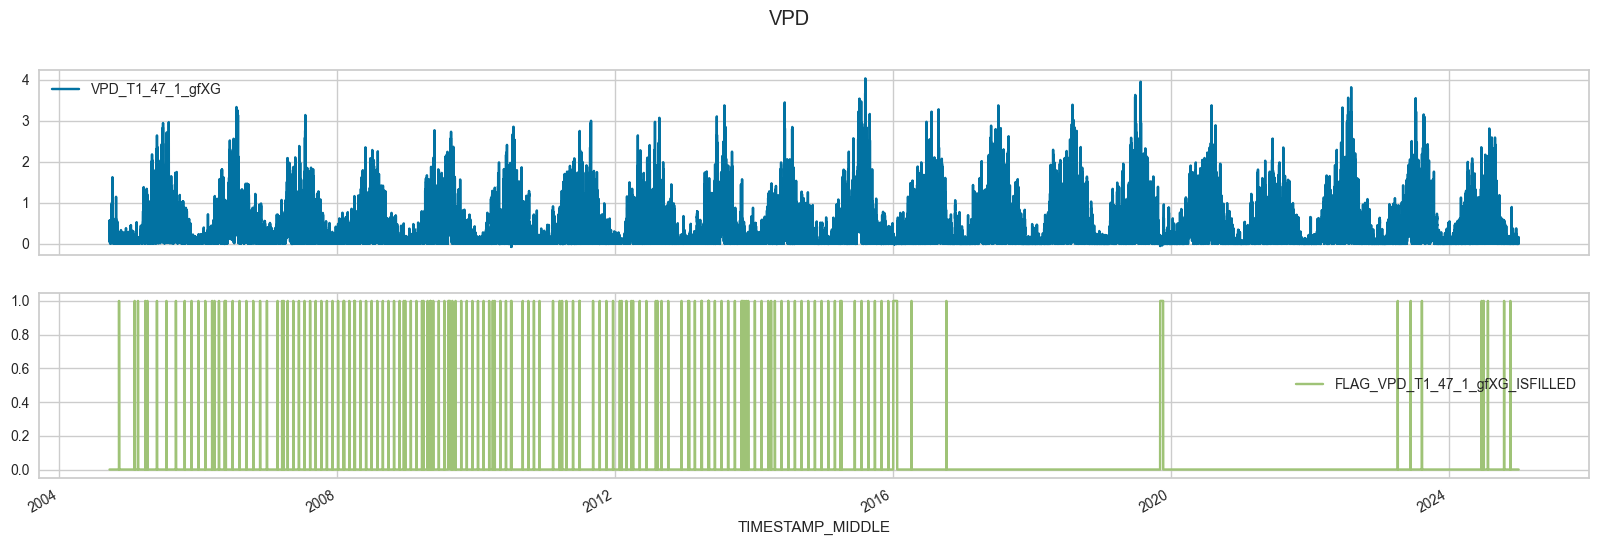

In [15]:
title = "VPD"
df[['VPD_T1_47_1_gfXG', 'FLAG_VPD_T1_47_1_gfXG_ISFILLED']].plot(x_compat=True, title=title, subplots=True, figsize=(20, 6));

</br>

# **Plots**

In [16]:
_plot_df = df.copy()
_plot_df = df.replace(-9999, np.nan)

## Time series plot

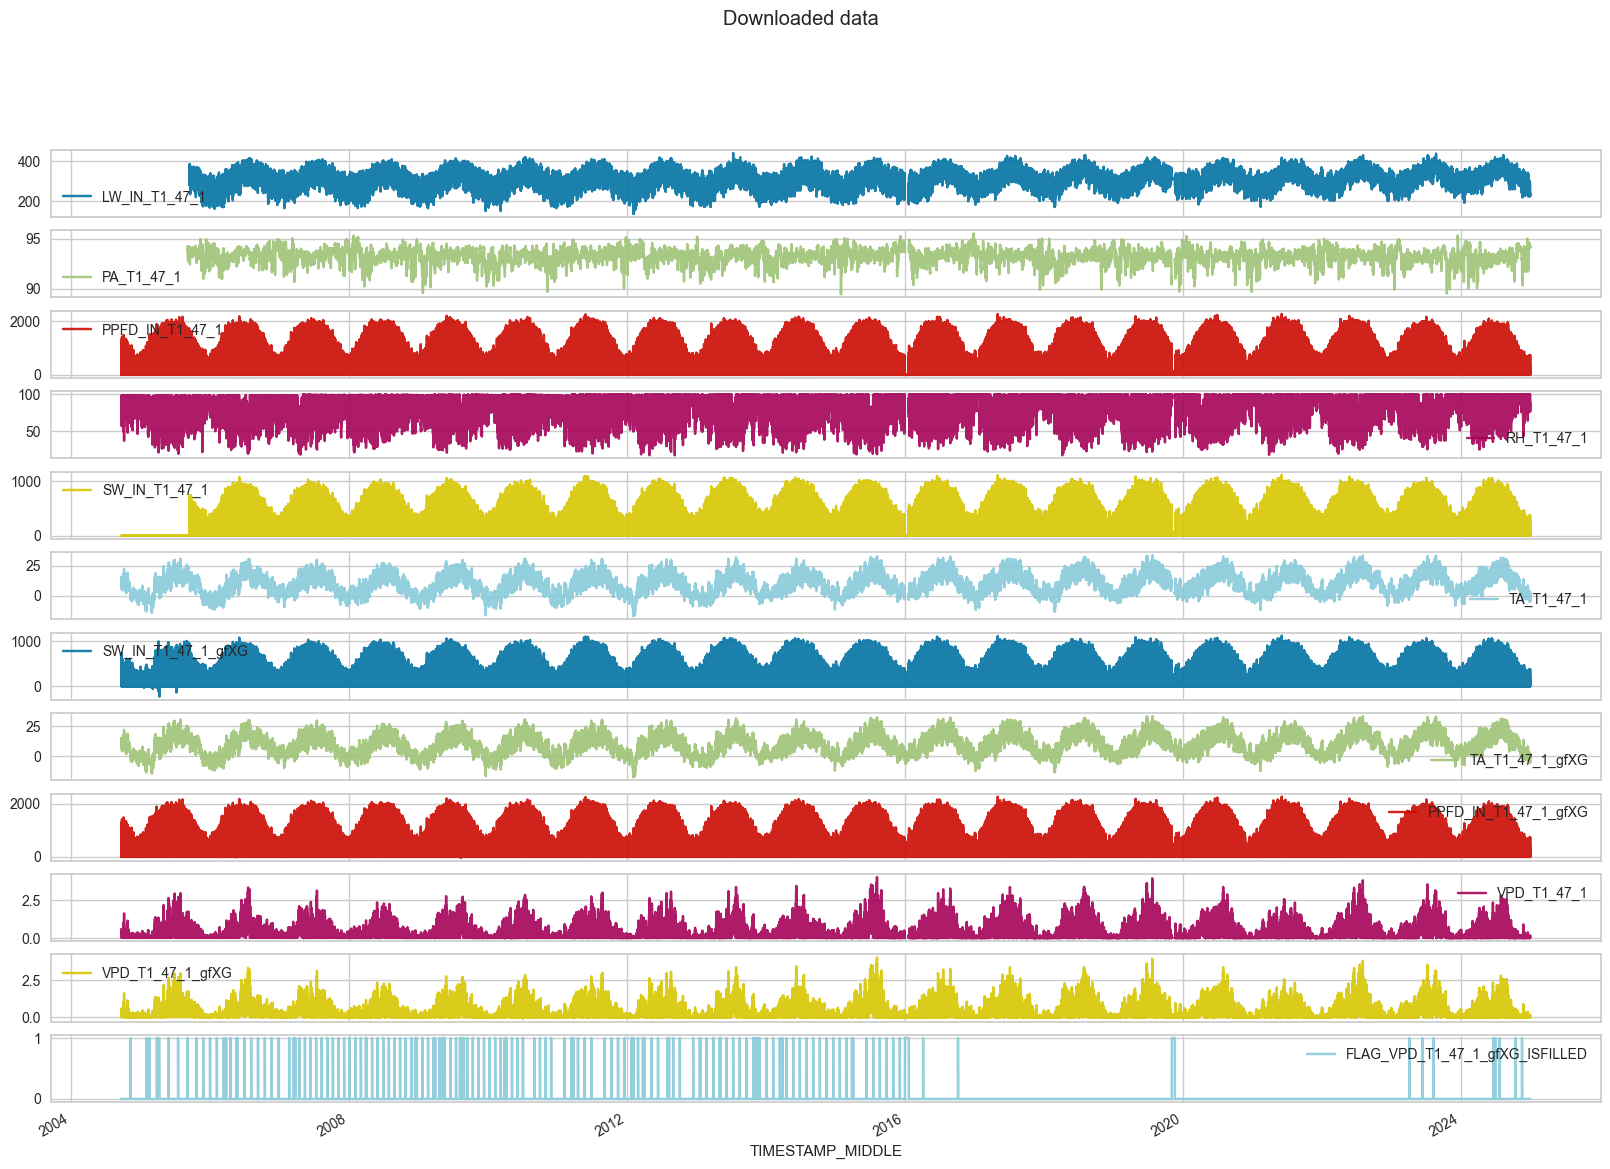

In [17]:
_plot_df.plot(subplots=True, figsize=(20, 14), title="Downloaded data", alpha=.9, x_compat=True);

## Heatmaps

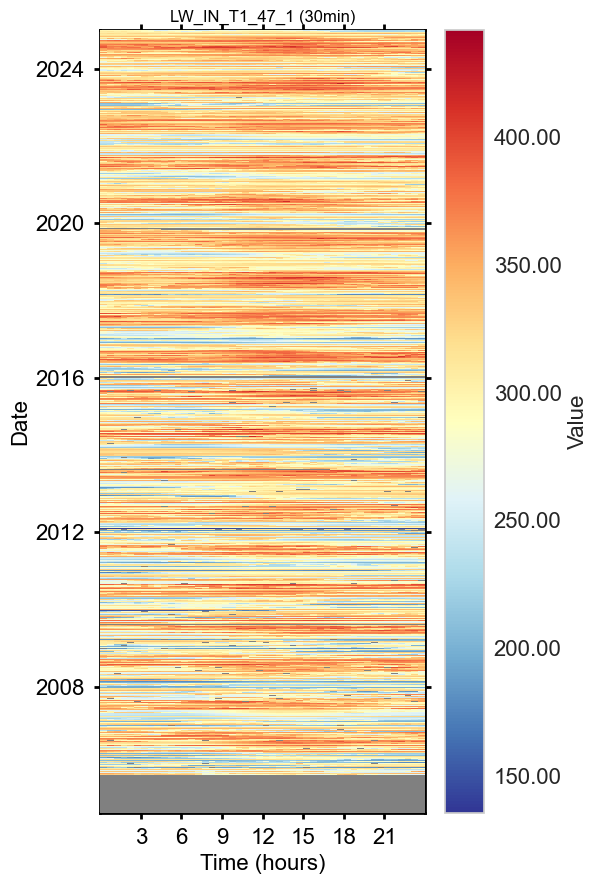

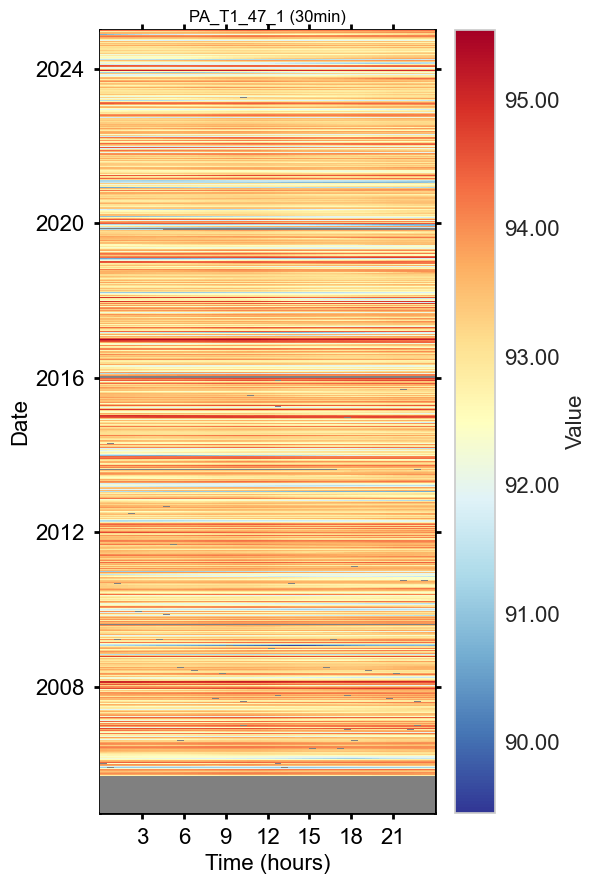

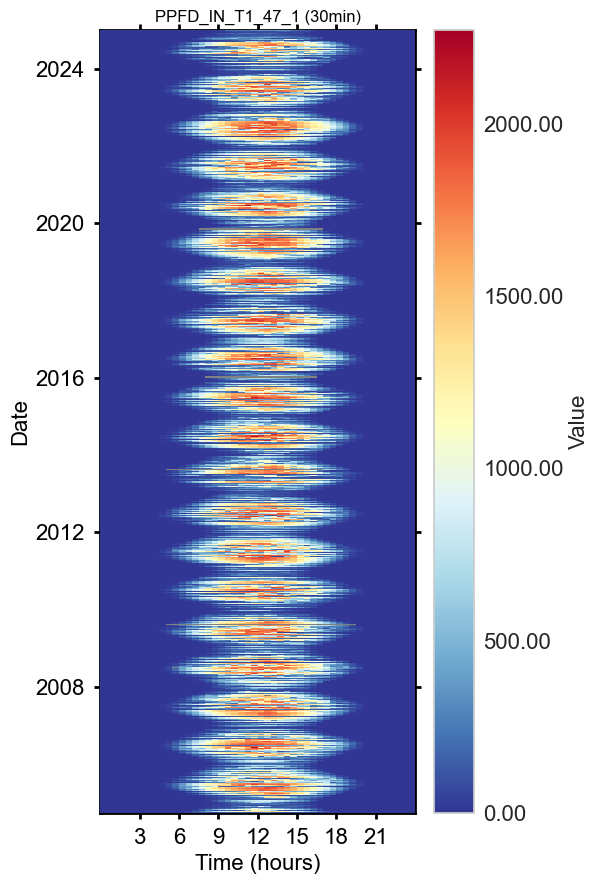

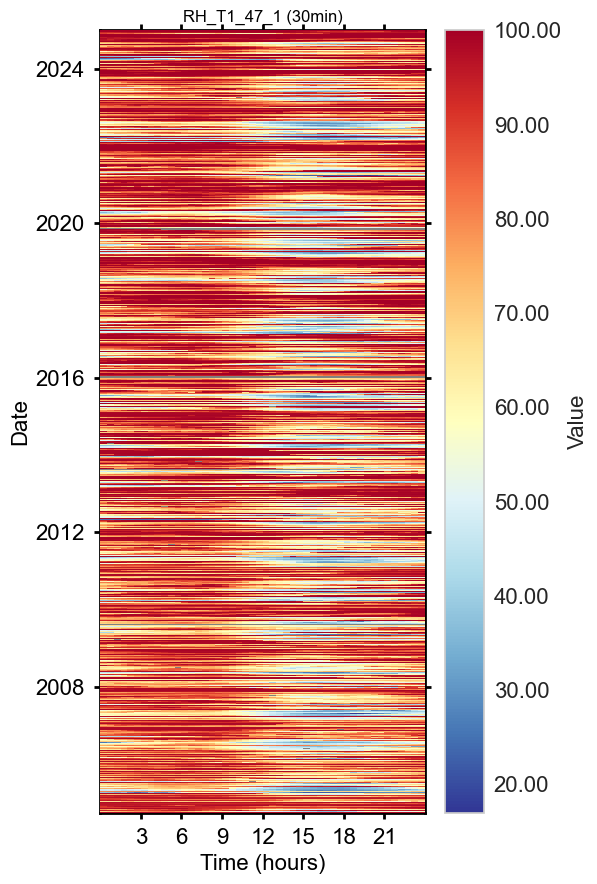

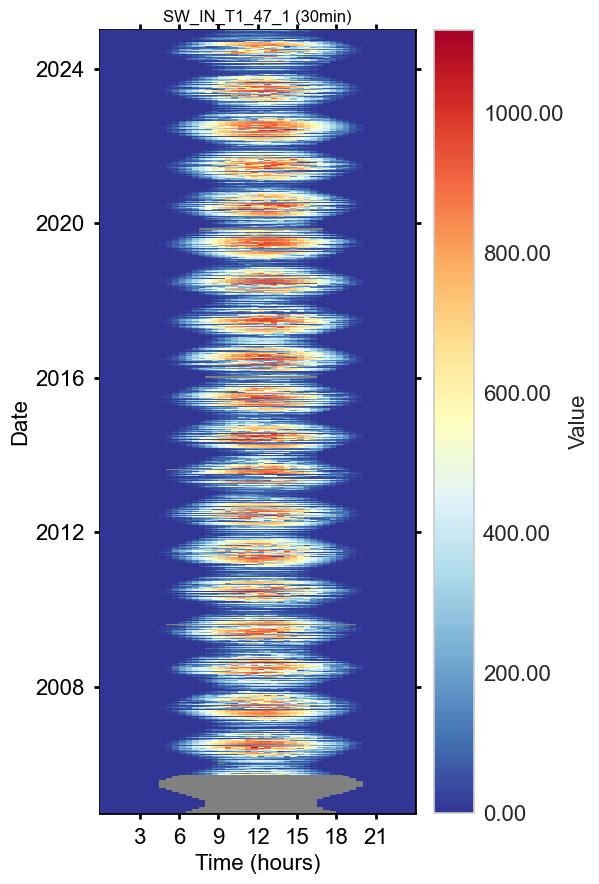

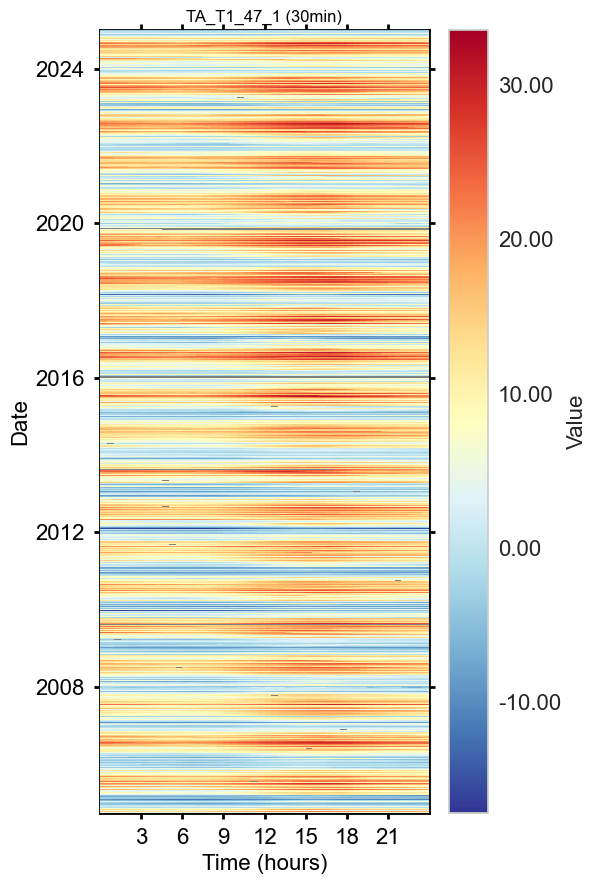

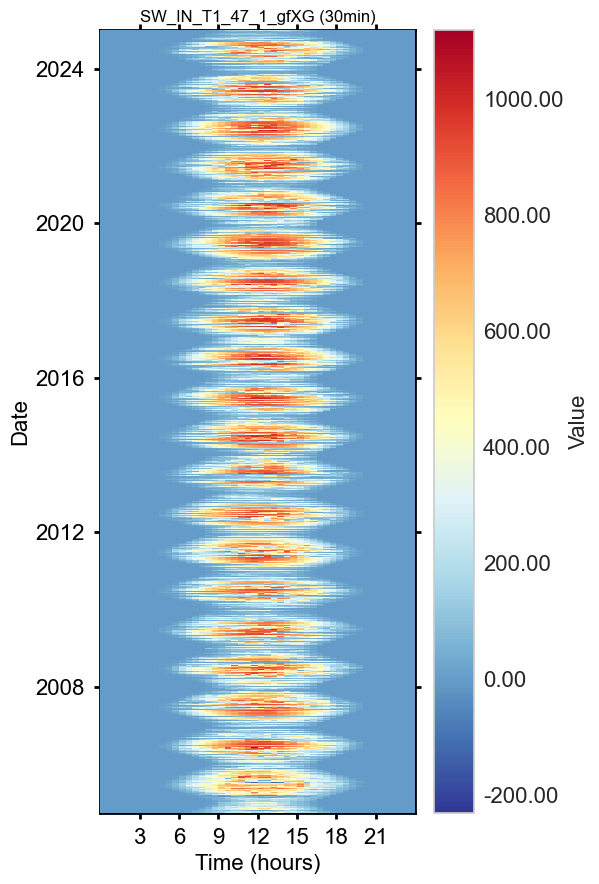

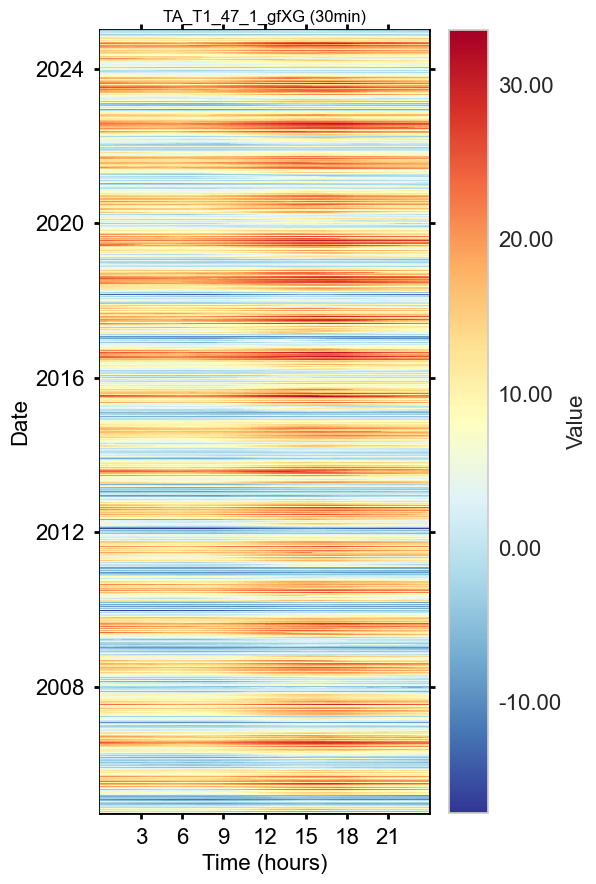

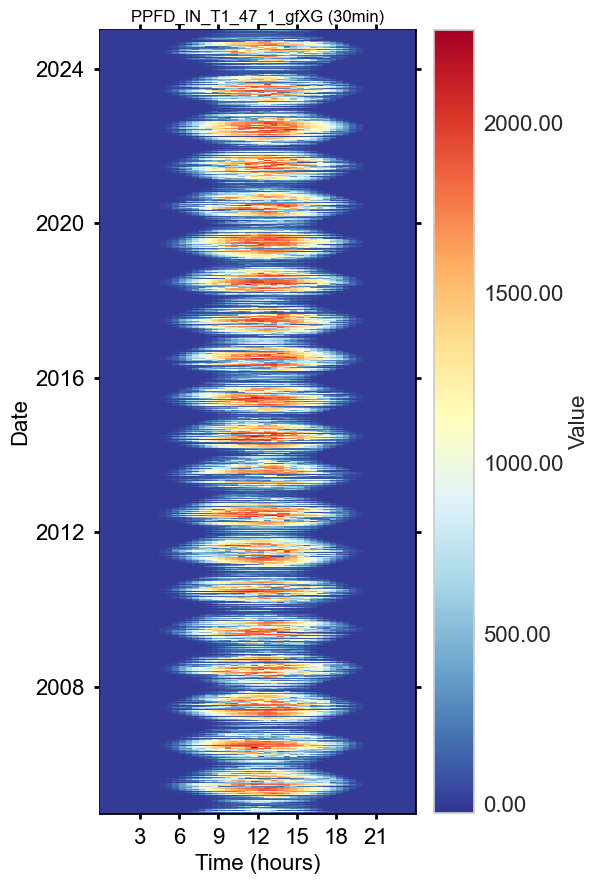

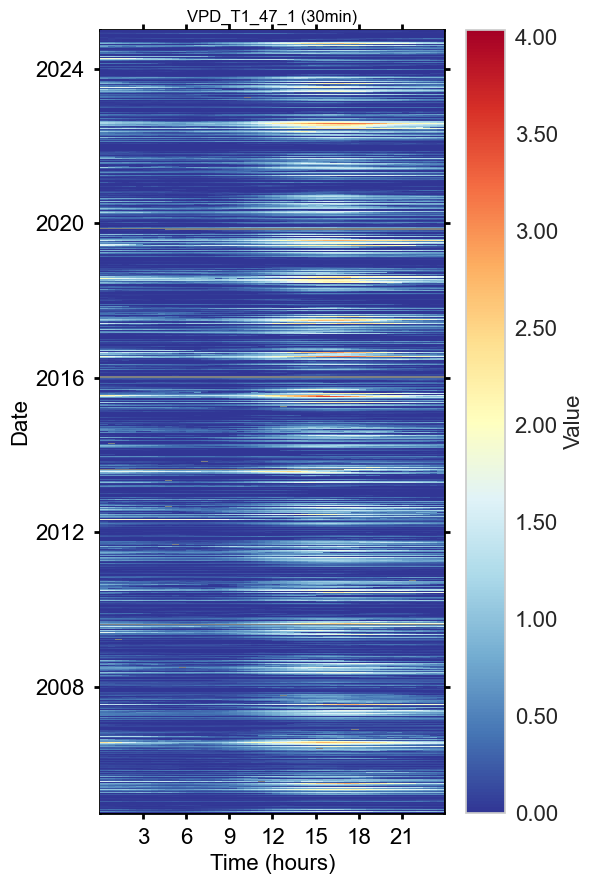

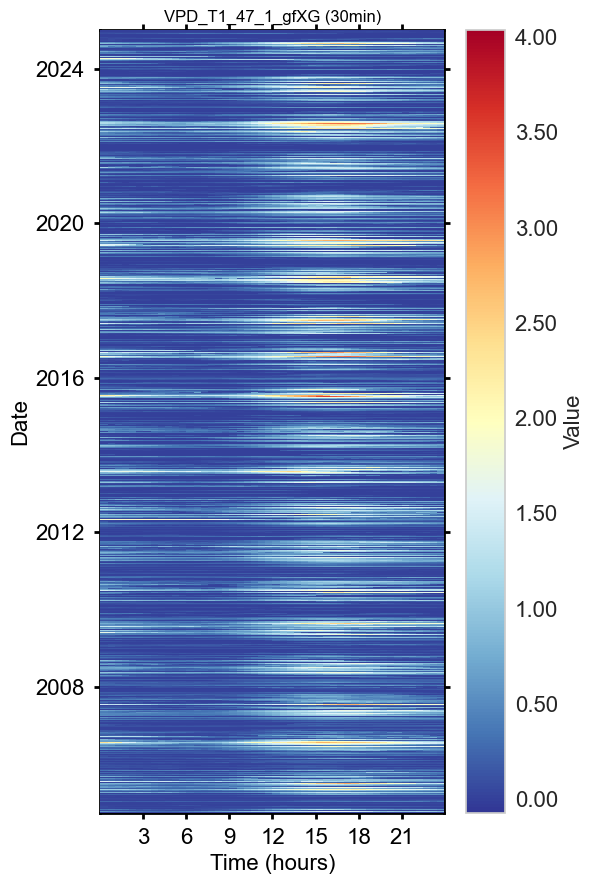

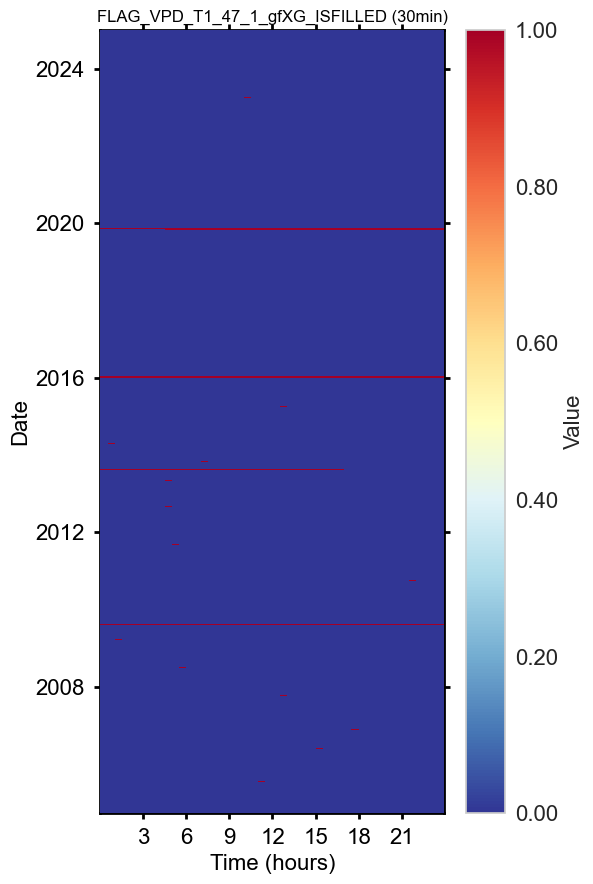

In [18]:
for col in _plot_df.columns:
    series = _plot_df[col]
    series.name = col
    dv.heatmapdatetime(series, figsize=(6, 9)).show()

</br>

# **Stats**

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LW_IN_T1_47_1,334651.0,310.191939,45.718410,135.445129,282.017899,315.560983,343.077050,441.779694
PA_T1_47_1,335887.0,93.234546,0.743782,89.446007,92.851006,93.309998,93.703298,95.543335
PPFD_IN_T1_47_1,354281.0,288.553030,486.866078,0.000000,0.000000,0.000000,369.686569,2270.612673
RH_T1_47_1,352774.0,79.283494,18.817820,16.934985,65.473702,82.847867,98.043015,100.000000
SW_IN_T1_47_1,345624.0,140.243968,237.022077,0.000000,0.000000,0.000000,182.744032,1118.665920
TA_T1_47_1,352760.0,8.898763,8.170412,-17.200001,2.581000,8.822186,14.940000,33.558765
SW_IN_T1_47_1_gfXG,355563.0,143.857556,237.390316,-231.742233,0.000000,0.000000,196.350212,1118.665920
TA_T1_47_1_gfXG,355563.0,8.885936,8.176580,-17.200001,2.549883,8.790000,14.945253,33.558765
PPFD_IN_T1_47_1_gfXG,355563.0,289.410291,487.053534,-26.199245,0.000000,0.000000,372.019762,2270.612673
VPD_T1_47_1,352774.0,0.351999,0.458276,0.000000,0.015304,0.170611,0.516567,4.035805


</br>

# Keep 7 meteo variables

In [20]:
# keepcols = [
#     'LW_IN_T1_2_1',
#     'PA_GF1_0.9_1',
#     'FLAG_PA_GF1_0.9_1_ISFILLED',
#     'PPFD_IN_T1_2_2',
#     'FLAG_PPFD_IN_T1_2_2_ISFILLED',
#     'VPD_T1_2_1',
#     'FLAG_VPD_T1_2_1_ISFILLED',
#     'SW_IN_T1_2_1',
#     'FLAG_SW_IN_T1_2_1_ISFILLED',
#     'TA_T1_2_1',
#     'FLAG_TA_T1_2_1_ISFILLED',
#     'RH_T1_2_1',
#     'FLAG_RH_T1_2_1_ISFILLED'    
# ]
# outdf = data_simple_2005_2024[keepcols].copy()
# outdf

</br>

# Save measured and gap-filled data to parquet

In [21]:
OUTNAME = "12.5_METEO_GAPFILLED_2004-2024"
OUTPATH = r""
filepath = save_parquet(filename=OUTNAME, data=df, outpath=OUTPATH)
# outdf.to_csv(Path(OUTPATH) / f"{OUTNAME}.csv")

Saved file 12.5_METEO_GAPFILLED_2004-2024.parquet (0.205 seconds).


</br>

# End of notebook.

In [22]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2025-06-11 23:53:09
